### Basic Skeleton Version1

##### Target:
1. Basic Skeleton of Squeeze and excitation model structure

##### Results:
1. Parameters: 13832
2. Best Train Accuracy: 99.16%
3. Best Test Accuracy: 98.63%

##### Analysis:
1. Model is having way more parameters than the requirement of less than 8000 parameters.
2. Model is overfitting.
3. Need to make a lighter model.

### import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

### Data Statics

In [3]:
simple_transforms = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST('./data',train = True,transform=simple_transforms,download=True)
exp_data = dataset.train_data
exp_data = dataset.transform(exp_data.numpy())

print('[Train]')
print('-Numpy Shape:',dataset.train_data.cpu().numpy().shape)
print('-Tensor Shape:',dataset.train_data.size())
print('-min:',torch.min(exp_data))
print('-max:',torch.max(exp_data))
print('-mean:',torch.mean(exp_data))
print('-std:',torch.std(exp_data))
print('-var:',torch.var(exp_data))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.34MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 157kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.22MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.55MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/opt/conda/envs/pytorch/lib/python3.11/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
-Numpy Shape: (60000, 28, 28)
-Tensor Shape: torch.Size([60000, 28, 28])
-min: tensor(0.)
-max: tensor(1.)
-mean: tensor(0.1307)
-std: tensor(0.3081)
-var: tensor(0.0949)


 ### Data Transformation

 We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [4]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))
     ]
)
test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

### Create Train and Test Data

In [5]:
train = datasets.MNIST('./data',train=True,transform=train_transforms)
test = datasets.MNIST('./data',train=False,transform=train_transforms)

### Dataloader Arguments

In [6]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available ?:",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4,pin_memory=True) if cuda else dict(shuffle=True,batch_size = 64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available ?: True


### The Model Architecture

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    #Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU()
    ) #Input size = 28, Output Size = 26, RFout = 3

    #Convolution Block 1
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU()
    ) #Input size = 26, Output Size = 24, RFout = 5

    #Transition Block 1
    self.pool1 = nn.MaxPool2d(2,2) #Input size = 24, Output Size = 12, RFout = 6
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=8,kernel_size=(1,1),padding=0,bias=False),
        nn.ReLU()
    )#Input size = 12, Output Size = 12, RFout = 6

    #Convolution Block 2
    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU()
    )#Input size = 12, Output Size = 10, RFout = 10
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU()
    )#Input size = 10, Output Size = 8, RFout = 14

    #Output block
    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=10,kernel_size=(1,1),padding=0,bias=False),
        nn.ReLU()
    )#Input size = 8, Output Size = 8, RFout = 14
    self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=10,kernel_size=(8,8),padding=0,bias=False),
    )#Input size = 8, Output Size = 1, RFout = 28

  def forward(self,x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)



### Check the model parameters

In [8]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
         MaxPool2d-5           [-1, 16, 12, 12]               0
            Conv2d-6            [-1, 8, 12, 12]             128
              ReLU-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           1,152
              ReLU-9           [-1, 16, 10, 10]               0
           Conv2d-10             [-1, 32, 8, 8]           4,608
             ReLU-11             [-1, 32, 8, 8]               0
           Conv2d-12             [-1, 10, 8, 8]             320
             ReLU-13             [-1, 10, 8, 8]               0
           Conv2d-14             [

Training and Testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

### Train the Model

In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
  print("EPOCH:",epoch)
  train(model, device,train_loader,optimizer,epoch)
  test(model,device,test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.23236404359340668 Batch_id=468 Accuracy=53.11: 100%|██████████| 469/469 [00:05<00:00, 85.58it/s] 



Test set: Average loss: 0.2194, Accuracy: 9354/10000 (93.54%)

EPOCH: 1


Loss=0.16079628467559814 Batch_id=468 Accuracy=95.30: 100%|██████████| 469/469 [00:04<00:00, 116.27it/s] 



Test set: Average loss: 0.1334, Accuracy: 9584/10000 (95.84%)

EPOCH: 2


Loss=0.24850022792816162 Batch_id=468 Accuracy=97.10: 100%|██████████| 469/469 [00:04<00:00, 116.36it/s] 



Test set: Average loss: 0.0766, Accuracy: 9759/10000 (97.59%)

EPOCH: 3


Loss=0.045844774693250656 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:04<00:00, 115.34it/s]



Test set: Average loss: 0.0643, Accuracy: 9802/10000 (98.02%)

EPOCH: 4


Loss=0.03028869442641735 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:04<00:00, 117.13it/s] 



Test set: Average loss: 0.0604, Accuracy: 9809/10000 (98.09%)

EPOCH: 5


Loss=0.0779225081205368 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:04<00:00, 114.15it/s]   



Test set: Average loss: 0.0564, Accuracy: 9831/10000 (98.31%)

EPOCH: 6


Loss=0.05981406569480896 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:04<00:00, 116.46it/s]  



Test set: Average loss: 0.0523, Accuracy: 9827/10000 (98.27%)

EPOCH: 7


Loss=0.04746759310364723 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:04<00:00, 115.40it/s]  



Test set: Average loss: 0.0488, Accuracy: 9837/10000 (98.37%)

EPOCH: 8


Loss=0.054197367280721664 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:04<00:00, 116.33it/s] 



Test set: Average loss: 0.0458, Accuracy: 9845/10000 (98.45%)

EPOCH: 9


Loss=0.006058415398001671 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:04<00:00, 115.89it/s] 



Test set: Average loss: 0.0450, Accuracy: 9843/10000 (98.43%)

EPOCH: 10


Loss=0.009970917366445065 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:03<00:00, 118.25it/s] 



Test set: Average loss: 0.0450, Accuracy: 9857/10000 (98.57%)

EPOCH: 11


Loss=0.025905972346663475 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:03<00:00, 117.72it/s] 



Test set: Average loss: 0.0415, Accuracy: 9858/10000 (98.58%)

EPOCH: 12


Loss=0.06487584114074707 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:04<00:00, 115.38it/s]  



Test set: Average loss: 0.0451, Accuracy: 9862/10000 (98.62%)

EPOCH: 13


Loss=0.02446831949055195 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:04<00:00, 114.33it/s]  



Test set: Average loss: 0.0425, Accuracy: 9863/10000 (98.63%)

EPOCH: 14


Loss=0.035337746143341064 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:04<00:00, 116.52it/s] 



Test set: Average loss: 0.0420, Accuracy: 9863/10000 (98.63%)



### Loss and Accuracy Plot

Text(0.5, 1.0, 'Test Accuracy')

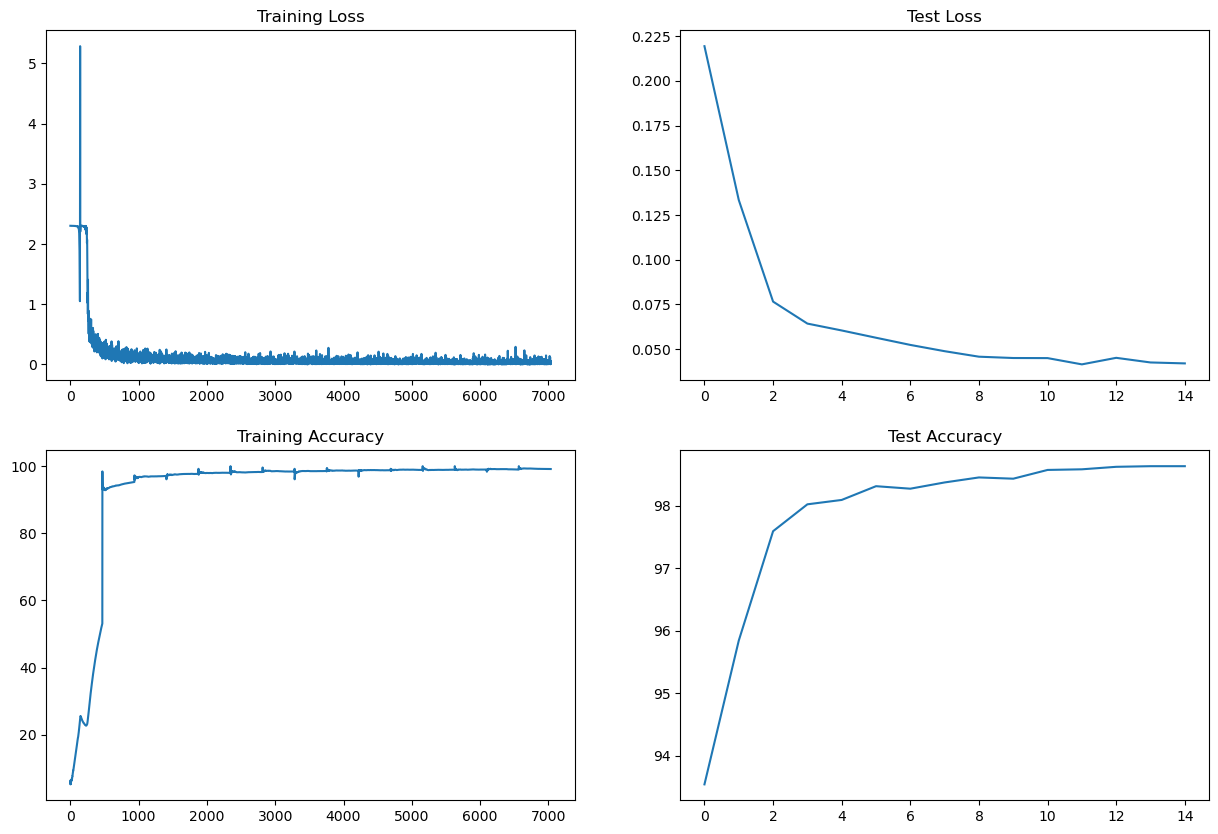

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
# Move tensors to CPU and convert to NumPy
train_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
train_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in train_acc]
test_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in test_losses]
test_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in test_acc]

axs[0, 0].plot(train_losses_cpu)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_cpu)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_cpu)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_cpu)
axs[1, 1].set_title("Test Accuracy")